# Brewing Logistic Regression then Going Deeper

While Caffe is made for deep networks it can likewise represent "shallow" models like logistic regression for classification. We'll do simple logistic regression on synthetic data that we'll generate and save to HDF5 to feed vectors to Caffe. Once that model is done, we'll add layers to improve accuracy. That's what Caffe is about: define a model, experiment, and then deploy.

Updated by [John Fogarty](https://github.com/jfogarty) for Python 3.6 and [Base2 MLI](https://github.com/base2solutions/mli) and [colab](https://colab.research.google.com) standalone evaluation.

In [0]:
class Context:
  CLEANUP = False  ## Delete files after a successful run.

#### Install caffe in colab

Please wait...

In [5]:
!apt install caffe-cpu
print("Done with Caffe install!")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
caffe-cpu is already the newest version (1.0.0-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Done!


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.chdir('..')

import sys
sys.path.insert(0, './python')
import caffe


import os
import h5py
import shutil
import tempfile

import sklearn
import sklearn.datasets
import sklearn.linear_model

import pandas as pd

Synthesize a dataset of 10,000 4-vectors for binary classification with 2 informative features and 2 noise features.

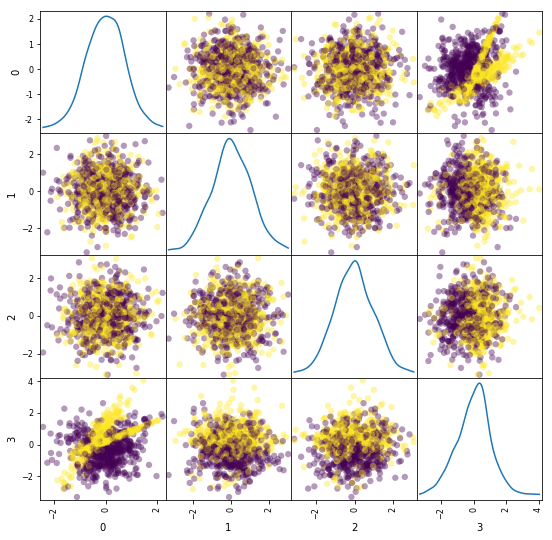

In [4]:
X, y = sklearn.datasets.make_classification(
    n_samples=10000, n_features=4, n_redundant=0, n_informative=2, 
    n_clusters_per_class=2, hypercube=False, random_state=0
)

# Split into train and test
X, Xt, y, yt = sklearn.model_selection.train_test_split(X, y)

# Visualize sample of the data
ind = np.random.permutation(X.shape[0])[:1000]
df = pd.DataFrame(X[ind])
_ = pd.plotting.scatter_matrix(df, figsize=(9, 9), diagonal='kde', marker='o', s=40, alpha=.4, c=y[ind])

Learn and evaluate scikit-learn's [logistic regression with stochastic gradient descent](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (SGD) training. Time and check the classifier's accuracy.

In [15]:
%%timeit -r 5 -n 2

# Train and test the scikit-learn SGD logistic regression.
clf = sklearn.linear_model.SGDClassifier(
    loss='log', max_iter=1000, penalty='l2', alpha=5e-4, class_weight='balanced')

clf.fit(X, y)
yt_pred = clf.predict(Xt)
print('Accuracy: {:.3f}'.format(sklearn.metrics.accuracy_score(yt, yt_pred)))

Accuracy: 0.739
Accuracy: 0.738
Accuracy: 0.612
Accuracy: 0.755
Accuracy: 0.742
Accuracy: 0.726
Accuracy: 0.748
Accuracy: 0.706
Accuracy: 0.760
Accuracy: 0.764
2 loops, best of 5: 19.5 ms per loop


Save the dataset to HDF5 for loading in Caffe.

In [0]:
# Write out the data to HDF5 files in a temp directory.
# This file is assumed to be caffe_root/examples/hdf5_classification.ipynb
dirname = os.path.abspath('./examples/hdf5_classification/data')
if not os.path.exists(dirname):
    os.makedirs(dirname)

train_filename = os.path.join(dirname, 'train.h5')
test_filename = os.path.join(dirname, 'test.h5')

# HDF5DataLayer source should be a file containing a list of HDF5 filenames.
# To show this off, we'll list the same data file twice.
with h5py.File(train_filename, 'w') as f:
    f['data'] = X
    f['label'] = y.astype(np.float32)
with open(os.path.join(dirname, 'train.txt'), 'w') as f:
    f.write(train_filename + '\n')
    f.write(train_filename + '\n')

# HDF5 is pretty efficient, but can be further compressed.
comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}
with h5py.File(test_filename, 'w') as f:
    f.create_dataset('data', data=Xt, **comp_kwargs)
    f.create_dataset('label', data=yt.astype(np.float32), **comp_kwargs)
with open(os.path.join(dirname, 'test.txt'), 'w') as f:
    f.write(test_filename + '\n')    

Let's define logistic regression in Caffe through Python net specification. This is a quick and natural way to define nets that sidesteps manually editing the protobuf model.

In [0]:
from caffe import layers as L
from caffe import params as P

def logreg(hdf5, batch_size):
    # logistic regression: data, matrix multiplication, and 2-class softmax loss
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    n.ip1 = L.InnerProduct(n.data, num_output=2, weight_filler=dict(type='xavier'))
    n.accuracy = L.Accuracy(n.ip1, n.label)
    n.loss = L.SoftmaxWithLoss(n.ip1, n.label)
    return n.to_proto()

train_net_path = 'examples/hdf5_classification/logreg_auto_train.prototxt'
with open(train_net_path, 'w') as f:
    f.write(str(logreg('examples/hdf5_classification/data/train.txt', 10)))

test_net_path = 'examples/hdf5_classification/logreg_auto_test.prototxt'
with open(test_net_path, 'w') as f:
    f.write(str(logreg('examples/hdf5_classification/data/test.txt', 10)))

Now, we'll define our "solver" which trains the network by specifying the locations of the train and test nets we defined above, as well as setting values for various parameters used for learning, display, and "snapshotting".

In [0]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and test networks.
    s.train_net = train_net_path
    s.test_net.append(test_net_path)

    s.test_interval = 1000  # Test after every 1000 training iterations.
    s.test_iter.append(250) # Test 250 "batches" each time we test.

    s.max_iter = 10000      # # of times to update the net (training iterations)

    # Set the initial learning rate for stochastic gradient descent (SGD).
    s.base_lr = 0.01        

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 5000

    # Set other optimization parameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- just once at the end of training.
    # For larger networks that take longer to train, you may want to set
    # snapshot < max_iter to save the network and training state to disk during
    # optimization, preventing disaster in case of machine crashes, etc.
    s.snapshot = 10000
    s.snapshot_prefix = 'examples/hdf5_classification/data/train'

    # We'll train on the CPU for fair benchmarking against scikit-learn.
    # Changing to GPU should result in much faster training!
    s.solver_mode = caffe_pb2.SolverParameter.CPU
    
    return s

solver_path = 'examples/hdf5_classification/logreg_solver.prototxt'
with open(solver_path, 'w') as f:
    f.write(str(solver(train_net_path, test_net_path)))

Time to learn and evaluate our Caffeinated logistic regression in Python.

In [24]:
%%timeit -n 1 -r 3
caffe.set_mode_cpu()
solver = caffe.get_solver(solver_path)
solver.solve()

accuracy = 0
batch_size = solver.test_nets[0].blobs['data'].num
test_iters = int(len(Xt) / batch_size)
for i in range(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters

print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.776
Accuracy: 0.776
Accuracy: 0.776
1 loop, best of 3: 198 ms per loop


In [28]:
!caffe train -solver examples/hdf5_classification/logreg_solver.prototxt

I0814 23:58:07.295397  2179 caffe.cpp:211] Use CPU.
I0814 23:58:07.295908  2179 solver.cpp:44] Initializing solver from parameters: 
train_net: "examples/hdf5_classification/logreg_auto_train.prototxt"
test_net: "examples/hdf5_classification/logreg_auto_test.prototxt"
test_iter: 250
test_interval: 1000
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 5000
snapshot: 10000
snapshot_prefix: "examples/hdf5_classification/data/train"
solver_mode: CPU
train_state {
  level: 0
  stage: ""
}
I0814 23:58:07.296085  2179 solver.cpp:77] Creating training net from train_net file: examples/hdf5_classification/logreg_auto_train.prototxt
I0814 23:58:07.296182  2179 net.cpp:51] Initializing net from parameters: 
state {
  phase: TRAIN
  level: 0
  stage: ""
}
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  hdf5_data_param {
    source: "examples/hdf5_classification/data/train.txt"
    batch_size: 10
  }
}
lay

If you look at output or the logreg_auto_train.prototxt, you'll see that the model is simple logistic regression. We can make it a little more advanced by introducing a non-linearity between weights that take the input and weights that give the output -- now we have a two-layer network. That network is given in nonlinear_auto_train.prototxt, and that's the only change made in nonlinear_logreg_solver.prototxt which we will now use.

The final accuracy of the new network should be higher than logistic regression!

In [0]:
from caffe import layers as L
from caffe import params as P

def nonlinear_net(hdf5, batch_size):
    # one small nonlinearity, one leap for model kind
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    # define a hidden layer of dimension 40
    n.ip1 = L.InnerProduct(n.data, num_output=40, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    # score the (now non-linear) features
    n.ip2 = L.InnerProduct(n.ip1, num_output=2, weight_filler=dict(type='xavier'))
    # same accuracy and loss as before
    n.accuracy = L.Accuracy(n.ip2, n.label)
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()

train_net_path = 'examples/hdf5_classification/nonlinear_auto_train.prototxt'
with open(train_net_path, 'w') as f:
    f.write(str(nonlinear_net('examples/hdf5_classification/data/train.txt', 10)))

test_net_path = 'examples/hdf5_classification/nonlinear_auto_test.prototxt'
with open(test_net_path, 'w') as f:
    f.write(str(nonlinear_net('examples/hdf5_classification/data/test.txt', 10)))

solver_path = 'examples/hdf5_classification/nonlinear_logreg_solver.prototxt'
with open(solver_path, 'w') as f:
    f.write(str(solver(train_net_path, test_net_path)))

Do the same through the command line interface for detailed output on the model and solving.

In [30]:
%%timeit -n 1 -r 3
caffe.set_mode_cpu()
solver = caffe.get_solver(solver_path)
solver.solve()

accuracy = 0
batch_size = solver.test_nets[0].blobs['data'].num
test_iters = int(len(Xt) / batch_size)
for i in range(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters

print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.830
Accuracy: 0.832
Accuracy: 0.834
1 loop, best of 3: 352 ms per loop


In [31]:
!caffe train -solver examples/hdf5_classification/nonlinear_logreg_solver.prototxt

I0815 00:01:20.426684  2238 caffe.cpp:211] Use CPU.
I0815 00:01:20.427106  2238 solver.cpp:44] Initializing solver from parameters: 
train_net: "examples/hdf5_classification/nonlinear_auto_train.prototxt"
test_net: "examples/hdf5_classification/nonlinear_auto_test.prototxt"
test_iter: 250
test_interval: 1000
base_lr: 0.01
display: 1000
max_iter: 10000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 5000
snapshot: 10000
snapshot_prefix: "examples/hdf5_classification/data/train"
solver_mode: CPU
train_state {
  level: 0
  stage: ""
}
I0815 00:01:20.427253  2238 solver.cpp:77] Creating training net from train_net file: examples/hdf5_classification/nonlinear_auto_train.prototxt
I0815 00:01:20.427350  2238 net.cpp:51] Initializing net from parameters: 
state {
  phase: TRAIN
  level: 0
  stage: ""
}
layer {
  name: "data"
  type: "HDF5Data"
  top: "data"
  top: "label"
  hdf5_data_param {
    source: "examples/hdf5_classification/data/train.txt"
    batch_size: 10


In [37]:
# Clean up files [change Context.CLEANUP to True unless you want to examine the hdf5_classification/data directory].
print(f"- All results were written to : {os.path.abspath(dirname)}")
if Context.CLEANUP:
    shutil.rmtree(dirname)
    print(f"- {os.path.abspath(dirname)} removed.")

- All results were written to : /examples/hdf5_classification/data


### End of notebook.